In [1]:
! pip install pymupdf

Defaulting to user installation because normal site-packages is not writeable


In [1]:
! pip install iso-639

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 167 kB 20.7 MB/s eta 0:00:01
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=169061 sha256=c53294aca48978ed33916a0c1b5438692717e9caddf1179dbd77f5a0f4f88ebe
  Stored in directory: /sfs/qumulo/qhome/hc5hq/.cache/pip/wheels/47/60/19/6d020fc92138ed1b113a18271e83ea4b5525fe770cb45b9a2e
Successfully built iso-639


In [76]:
import fitz
from iso639 import languages

In [69]:
import pandas as pd
import numpy as np
import pprint
import PyPDF2
import pdfminer
import pymc3 as pm
import os
import glob
import random
from langdetect import detect
from langdetect import detect_langs

In [77]:
def randomFiles(location):
    randomFilesDF = pd.DataFrame()
    for i in location:
        pdffiles = sorted(glob.glob(i + '*.pdf'))
        pdffiles = pd.DataFrame({'filePath' : pdffiles})
        result = pdffiles.sample(40,  random_state = np.random.RandomState(10))
        randomFilesDF = pd.concat([randomFilesDF, result])
    return randomFilesDF

In [78]:
randomFilesDF = randomFiles(["/scratch/yte9pc/InternetArchive/Datasets/fatcat_longtail_lang/", 
             "/scratch/yte9pc/InternetArchive/Datasets/fatcat_pdf/",
             "/scratch/yte9pc/InternetArchive/Datasets/gwb_random_pdf/"])

In [79]:
BayesDF = pd.read_csv('Final_BayesProject_PDFs.csv')
BayesDF.columns = ['index', 'filePath', 'researchPublication']
BayesDF = BayesDF.drop(columns = ['index'])
BayesDF

,filePath,researchPublication
0,/scratch/yte9pc/InternetArchive/Datasets/fatca...,0
1,/scratch/yte9pc/InternetArchive/Datasets/fatca...,1
2,/scratch/yte9pc/InternetArchive/Datasets/fatca...,0
3,/scratch/yte9pc/InternetArchive/Datasets/fatca...,0
4,/scratch/yte9pc/InternetArchive/Datasets/fatca...,1
...,...,...
115,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0
116,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0
117,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0
118,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,0


In [80]:
class ParsePDF:
    def __init__(self, pdfPath):
        self.pdfPath = pdfPath
        self.fileName = None
        self.doc = None
        self.numPages = None
        self.toc = None
        self.metadata = None
        self.format = None
        self.title = None
        self.author = None
        self.subject = None
        self.creator = None
        self.producer = None
        self.allText = ''
        self.pageText = ''
        self.parsable = None
    
    def getMetaData(self):
        self.fileName = self.pdfPath.split('/')[-1]
        try:
            # Open the PDF
            self.doc = fitz.open(self.pdfPath)
            self.numPages = self.doc.pageCount
            if not self.doc.getToC():
                self.toc = False
            else:
                self.toc = True
            self.metadata = self.doc.metadata
            self.png = self.doc.loadPage(0).getPixmap()
            self.format = self.metadata.get('format')
            self.title = self.metadata.get('title')
            self.author = self.metadata.get('author')
            self.subject = self.metadata.get('subject')
            self.creator = self.metadata.get('creator')
            self.producer = self.metadata.get('producer')
            self.doc.close()
            return [self.pdfPath, self.fileName, self.numPages, self.toc, 
                    self.format, self.title, self.author, self.subject, self.creator, 
                    self.producer, self.png.height, self.png.width, self.png.size]
        except Exception:
            return [self.pdfPath, self.fileName] + [np.nan] * 11
    
    def getTOC(self):
        self.doc = fitz.open(self.pdfPath)
        try:
            if not doc.getToC():
                return np.nan
            else:
                return doc.getToC()
        except Exception:
            return np.nan
        
    def getPageImage(self, pageNum):
        self.doc = fitz.open(self.pdfPath)
        try:
            if pageNum <= self.doc.pageCount:
                png = self.doc.loadPage(pageNum).getPixmap()
                png.writeImage("%s-%i.png" % (self.pdfPath.split('/')[-1].strip('.png'), pageNum))
                return 'Image Saved'
        except Exception:
            return 'Error getting image'
        
    def getImageSpecs(self, pageNum):
        self.doc = fitz.open(self.pdfPath)
        try:
            if pageNum <= self.doc.pageCount:
                png = self.doc.loadPage(pageNum).getPixmap()
                return [png.height, png.width, png.size]
        except Exception:
            return [np.nan] * 3
        
    # https://pymupdf.readthedocs.io/en/latest/vars.html#textpreserve
    def getAllText(self, opt = 'text'):
        self.doc = fitz.open(self.pdfPath)
        for i in range(0, self.doc.pageCount):
            self.allText += self.doc.loadPage(i).getText(opt, flags = fitz.TEXT_DEHYPHENATE)\
                            .replace('\n', ' ').strip() + ' '
        return self.allText
    
    def getPageText(self, pageNum, opt = 'text'):
        self.doc = fitz.open(self.pdfPath)
        try:
            if pageNum <= self.doc.pageCount:
                self.pageText = self.doc.loadPage(pageNum).getText(opt, flags = fitz.TEXT_DEHYPHENATE)\
                                .replace('\n', ' ').strip()
                return self.pageText
        except Exception:
            return self.pageText 

In [81]:
def metaData(PDFs):
    metaDataDF = pd.DataFrame()
    for pdf in PDFs:
        p = ParsePDF(pdf)
        df = pd.DataFrame(p.getMetaData(), 
            index = ['filePath', 'fileName', 'numPages', 'toc', 'format', 'title', 
                     'author', 'subject', 'creator', 'producer', 
                     'height', 'width', 'size']).transpose()
        metaDataDF = metaDataDF.append(df, ignore_index = True)
    return metaDataDF

In [82]:
%time meta = metaData(BayesDF.filePath.values)

mupdf: expected object number
mupdf: No default Layer config
mupdf: cannot find startxref


CPU times: user 3.01 s, sys: 394 ms, total: 3.4 s
Wall time: 1min 51s


__*Some files are not in english*__

- Words that represent the structure of a paper
    - abtract, introduction, conclusion, reference, table of content
- Words that represent the content of a paper
    - research, analyze, result, table, investigation, explain, theory, study, paper, data, perform
- Words that represent association
    - journal, association, organization, doi, university, school, board

In [83]:
struct = ['abstract', 'introduction', 'conclusion', 'reference', 'table of content']
content = ['research', 'analyze', 'result', 'table', 'investigation', 'explain', 'theor', 'stud', 'paper', 'data', 'perform']
assoc = ['journal', 'association', 'assoc', 'organization', 'doi', 'university', 'school', 'board', 'publish']
types = {'structure' : struct, 'content' : content, 'association' : assoc}

In [84]:
def searchFor(listWords):
    words = []
    PDFs = meta.filePath.values
    for pdf in PDFs:
        p = ParsePDF(pdf)
        text = p.getAllText()
        textLength.append(len(text))
        fileWordCount = []
        for i in listWords:
            fileWordCount.append(text.lower().count(i))
        words.append(fileWordCount)
    meta['numChar'] = textLength
    meta['words'] = textLength
    return words

def searchFor(dictionaryWords):
    lang = []
    textLength = []
    typeCount = {'structure' : [], 'content' : [], 'association' : []}
    PDFs = meta.filePath.values
    for pdf in PDFs:
        p = ParsePDF(pdf)
        text = p.getAllText()
        try:
            lang.append(languages.get(alpha2 = detect(text)).name)
        except:
            lang.append(np.nan)
        textLength.append(len(text))
        for i in dictionaryWords:
            wordTypeCount = 0
            for j in dictionaryWords[i]:
                wordTypeCount += text.lower().count(j)
            typeCount[i].append(wordTypeCount)
            
    meta['structure'] = typeCount['structure']
    meta['content'] = typeCount['content']
    meta['association'] = typeCount['association']
    meta['language'] = lang
    meta['numChar'] = textLength

In [85]:
%time searchFor(types)

mupdf: expected object number
mupdf: No default Layer config
mupdf: cannot find startxref


CPU times: user 8.13 s, sys: 108 ms, total: 8.24 s
Wall time: 8.54 s


In [86]:
dataset = meta[['filePath', 'numPages', 'height', 'width', 'size', 'structure', 'content', 'association', 'language', 'numChar']]

In [87]:
dataset = dataset.merge(BayesDF, left_on = 'filePath', right_on = 'filePath')

In [88]:
finalDataset = dataset[~dataset.numPages.isnull()]

In [89]:
finalDataset

,filePath,numPages,height,width,size,structure,content,association,language,numChar,researchPublication
0,/scratch/yte9pc/InternetArchive/Datasets/fatca...,2,828,602,1495456,0,0,0,Polish,6943,0
1,/scratch/yte9pc/InternetArchive/Datasets/fatca...,10,794,595,1417378,2,20,50,Korean,27885,1
2,/scratch/yte9pc/InternetArchive/Datasets/fatca...,14,1243,773,2882605,0,0,0,NaN,14,0
3,/scratch/yte9pc/InternetArchive/Datasets/fatca...,4,794,595,1417378,2,1,4,English,9119,0
4,/scratch/yte9pc/InternetArchive/Datasets/fatca...,4,842,595,1503058,0,71,2,Norwegian,25615,1
...,...,...,...,...,...,...,...,...,...,...,...
115,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,12,842,596,1505584,0,0,0,English,17184,0
116,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,4,842,596,1505584,2,59,1,English,5984,0
117,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,2,842,596,1505584,0,1,1,English,4240,0
118,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,2,595,841,1501273,1,4,0,English,3803,0


### Lanaguge distribution across researchPublication

In [90]:
## use df3 to check lanaguge distribution across researchPublication
df3 = finalDataset

In [93]:
replace_map = {1: 'researchPublication', 0: 'not_researchPublication'}
df3.researchPublication  = df3.researchPublication.map(replace_map)
df3

/home/hc5hq/.local/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,filePath,numPages,height,width,size,structure,content,association,language,numChar,researchPublication
0,/scratch/yte9pc/InternetArchive/Datasets/fatca...,2,828,602,1495456,0,0,0,Polish,6943,not_researchPublication
1,/scratch/yte9pc/InternetArchive/Datasets/fatca...,10,794,595,1417378,2,20,50,Korean,27885,researchPublication
2,/scratch/yte9pc/InternetArchive/Datasets/fatca...,14,1243,773,2882605,0,0,0,NaN,14,not_researchPublication
3,/scratch/yte9pc/InternetArchive/Datasets/fatca...,4,794,595,1417378,2,1,4,English,9119,not_researchPublication
4,/scratch/yte9pc/InternetArchive/Datasets/fatca...,4,842,595,1503058,0,71,2,Norwegian,25615,researchPublication
...,...,...,...,...,...,...,...,...,...,...,...
115,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,12,842,596,1505584,0,0,0,English,17184,not_researchPublication
116,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,4,842,596,1505584,2,59,1,English,5984,not_researchPublication
117,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,2,842,596,1505584,0,1,1,English,4240,not_researchPublication
118,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,2,595,841,1501273,1,4,0,English,3803,not_researchPublication


### Lanaguge distribution across researchPublication bar plot

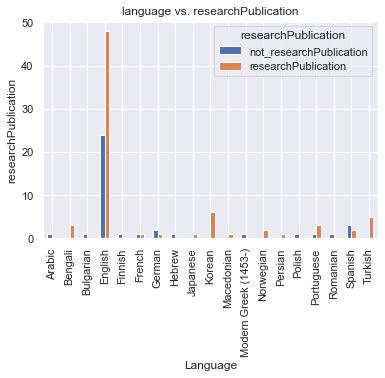

In [94]:
%matplotlib inline
pd.crosstab(finalDataset.language,finalDataset.researchPublication).plot(kind='bar')
plt.title('language vs. researchPublication')
plt.xlabel('Language')
plt.ylabel('researchPublication')
plt.savefig('featureAnalysis')

### Change language into 1, 2, 3 codes

In [16]:
def dfmap(i):
    langeCode = []
    if str(i) in ('English'):
        return '1'
    elif str(i) in ('French', 'Spanish', 'Portuguese', 'Romanian'):
        return '2'
    else:
        return '3'

In [17]:
finalDataset.language = finalDataset.language.apply(dfmap)

/home/hc5hq/.local/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [18]:
finalDataset

,filePath,numPages,height,width,size,structure,content,association,language,numChar,researchPublication
0,/scratch/yte9pc/InternetArchive/Datasets/fatca...,2,828,602,1495456,0,0,0,3,6943,0
1,/scratch/yte9pc/InternetArchive/Datasets/fatca...,10,794,595,1417378,2,20,50,3,27885,1
2,/scratch/yte9pc/InternetArchive/Datasets/fatca...,14,1243,773,2882605,0,0,0,3,14,0
3,/scratch/yte9pc/InternetArchive/Datasets/fatca...,4,794,595,1417378,2,1,4,1,9119,0
4,/scratch/yte9pc/InternetArchive/Datasets/fatca...,4,842,595,1503058,0,71,2,3,25615,1
...,...,...,...,...,...,...,...,...,...,...,...
115,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,12,842,596,1505584,0,0,0,1,17184,0
116,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,4,842,596,1505584,2,59,1,1,5984,0
117,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,2,842,596,1505584,0,1,1,1,4240,0
118,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,2,595,841,1501273,1,4,0,1,3803,0


### Bayes model construction

In [19]:
df = finalDataset

In [57]:
df1 = finalDataset

In [58]:
df1

,filePath,numPages,height,width,size,structure,content,association,language,numChar,researchPublication
0,/scratch/yte9pc/InternetArchive/Datasets/fatca...,2,828,602,1495456,0,0,0,3,6943,0
1,/scratch/yte9pc/InternetArchive/Datasets/fatca...,10,794,595,1417378,2,20,50,3,27885,1
2,/scratch/yte9pc/InternetArchive/Datasets/fatca...,14,1243,773,2882605,0,0,0,3,14,0
3,/scratch/yte9pc/InternetArchive/Datasets/fatca...,4,794,595,1417378,2,1,4,1,9119,0
4,/scratch/yte9pc/InternetArchive/Datasets/fatca...,4,842,595,1503058,0,71,2,3,25615,1
...,...,...,...,...,...,...,...,...,...,...,...
115,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,12,842,596,1505584,0,0,0,1,17184,0
116,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,4,842,596,1505584,2,59,1,1,5984,0
117,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,2,842,596,1505584,0,1,1,1,4240,0
118,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,2,595,841,1501273,1,4,0,1,3803,0


In [1]:
## reserve df1 dataset: 1 for researchPublication and 0: not_rearchPulication for fuether EDA

In [61]:
replace_map = {1: 'researchPublication', 0: 'not_researchPublication'}
df1.researchPublication  = df1.researchPublication.map(replace_map)
df1

/home/hc5hq/.local/lib/python3.7/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,filePath,numPages,height,width,size,structure,content,association,language,numChar,researchPublication
0,/scratch/yte9pc/InternetArchive/Datasets/fatca...,2,828,602,1495456,0,0,0,3,6943,not_researchPublication
1,/scratch/yte9pc/InternetArchive/Datasets/fatca...,10,794,595,1417378,2,20,50,3,27885,researchPublication
2,/scratch/yte9pc/InternetArchive/Datasets/fatca...,14,1243,773,2882605,0,0,0,3,14,not_researchPublication
3,/scratch/yte9pc/InternetArchive/Datasets/fatca...,4,794,595,1417378,2,1,4,1,9119,not_researchPublication
4,/scratch/yte9pc/InternetArchive/Datasets/fatca...,4,842,595,1503058,0,71,2,3,25615,researchPublication
...,...,...,...,...,...,...,...,...,...,...,...
115,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,12,842,596,1505584,0,0,0,1,17184,not_researchPublication
116,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,4,842,596,1505584,2,59,1,1,5984,not_researchPublication
117,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,2,842,596,1505584,0,1,1,1,4240,not_researchPublication
118,/scratch/yte9pc/InternetArchive/Datasets/gwb_r...,2,595,841,1501273,1,4,0,1,3803,not_researchPublication


In [2]:
## Check datatype

In [20]:
df.dtypes

filePath               object
numPages               object
height                 object
width                  object
size                   object
structure               int64
content                 int64
association             int64
language               object
numChar                 int64
researchPublication     int64
dtype: object

In [3]:
## Convert object to int type

In [21]:
mycol = ["numPages", "height", "width", "size", "structure", "content", "association", "language", "numChar", "researchPublication"]
df = df[mycol].astype(int)

In [22]:
df = df.rename(columns = {'size':'dim'})

In [23]:
finalDataset.to_csv('FinalDatasetBayes.csv')

In [24]:
## rename size as dim- preserved key word 

In [25]:
# Normalization
# Standardize the data (mean for each numerical variable of zero, standard deviation of one.)
for key in df.keys()[0:9]:
    try:
        print("Standardizing "+key+".")
        df[key] = df[key] - np.mean(df[key])
        df[key] = df[key] / np.std(df[key])
    except:
        print("Predictor "+key+" cannot be standardized (probably a categorical variable).")
df.describe()

Standardizing numPages.
Standardizing height.
Standardizing width.
Standardizing dim.
Standardizing structure.
Standardizing content.
Standardizing association.
Standardizing language.
Standardizing numChar.


,numPages,height,width,dim,structure,content,association,language,numChar,researchPublication
count,1.190000e+02,1.190000e+02,1.190000e+02,1.190000e+02,1.190000e+02,1.190000e+02,1.190000e+02,1.190000e+02,1.190000e+02,119.000000
mean,-1.119553e-17,-3.134747e-16,-4.179663e-16,-1.044916e-16,4.944691e-17,2.892178e-17,-5.271227e-17,1.492737e-16,-5.831003e-18,0.638655
std,1.004228e+00,1.004228e+00,1.004228e+00,1.004228e+00,1.004228e+00,1.004228e+00,1.004228e+00,1.004228e+00,1.004228e+00,0.482421
min,-5.751331e-01,-1.853064e+00,-2.406564e+00,-1.744518e+00,-6.427803e-01,-6.098583e-01,-4.424814e-01,-7.692159e-01,-6.173851e-01,0.000000
25%,-4.750002e-01,-1.202846e-01,-6.702275e-02,-6.937910e-02,-6.427803e-01,-6.098583e-01,-4.424814e-01,-7.692159e-01,-5.054366e-01,0.000000
50%,-2.747344e-01,-1.889854e-02,-5.520689e-02,1.988518e-02,-3.771870e-01,-4.299435e-01,-2.762715e-01,-7.692159e-01,-2.384204e-01,1.000000
75%,-7.446859e-02,4.235133e-01,1.220311e-01,1.415030e-01,1.539994e-01,4.233290e-02,-1.033574e-02,1.463386e+00,1.078474e-02,1.000000
max,5.282642e+00,7.474451e+00,6.089042e+00,9.312402e+00,4.934678e+00,4.135395e+00,7.967738e+00,1.463386e+00,6.781893e+00,1.000000


In [26]:
df

,numPages,height,width,dim,structure,content,association,language,numChar,researchPublication
0,-0.525067,0.294476,0.015688,0.117532,-0.642780,-0.609858,-0.442481,1.463386,-0.470365,0
1,-0.124535,-0.018899,-0.067023,-0.067267,-0.111594,-0.160071,1.219617,1.463386,-0.026849,1
2,0.075731,4.119495,2.036201,3.400695,-0.642780,-0.609858,-0.442481,1.463386,-0.617110,0
3,-0.424934,-0.018899,-0.067023,-0.067267,-0.111594,-0.587369,-0.309514,-0.769216,-0.424281,0
4,-0.424934,0.423513,-0.067023,0.135524,-0.642780,0.986886,-0.375997,1.463386,-0.074924,1
...,...,...,...,...,...,...,...,...,...,...
115,-0.024402,0.423513,-0.055207,0.141503,-0.642780,-0.609858,-0.442481,-0.769216,-0.253478,0
116,-0.424934,0.423513,-0.055207,0.141503,-0.111594,0.717013,-0.409239,-0.769216,-0.490675,0
117,-0.525067,0.423513,-0.055207,0.141503,-0.642780,-0.587369,-0.409239,-0.769216,-0.527610,0
118,-0.525067,-1.853064,2.839680,0.131300,-0.377187,-0.519901,-0.442481,-0.769216,-0.536865,0


## PyMC3 model application

In [27]:
## apply pm model using GLM function
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula('df.researchPublication~ df.numPages + df.height + df.width + df.dim + df.structure + df.content + df.association + df.association + df.language + df.numChar',
                            df,
                            family=pm.glm.families.Binomial())
    trace = pm.sample(5000, tune=5000, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [df.numChar, df.language, df.association, df.content, df.structure, df.dim, df.width, df.height, df.numPages, Intercept]


Sampling 4 chains for 5_000 tune and 5_000 draw iterations (20_000 + 20_000 draws total) took 54 seconds.
There were 4199 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5607687778498095, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3486 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3340 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3942 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/hc5hq/.local/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5a6817bd0>,
      dtype=object)

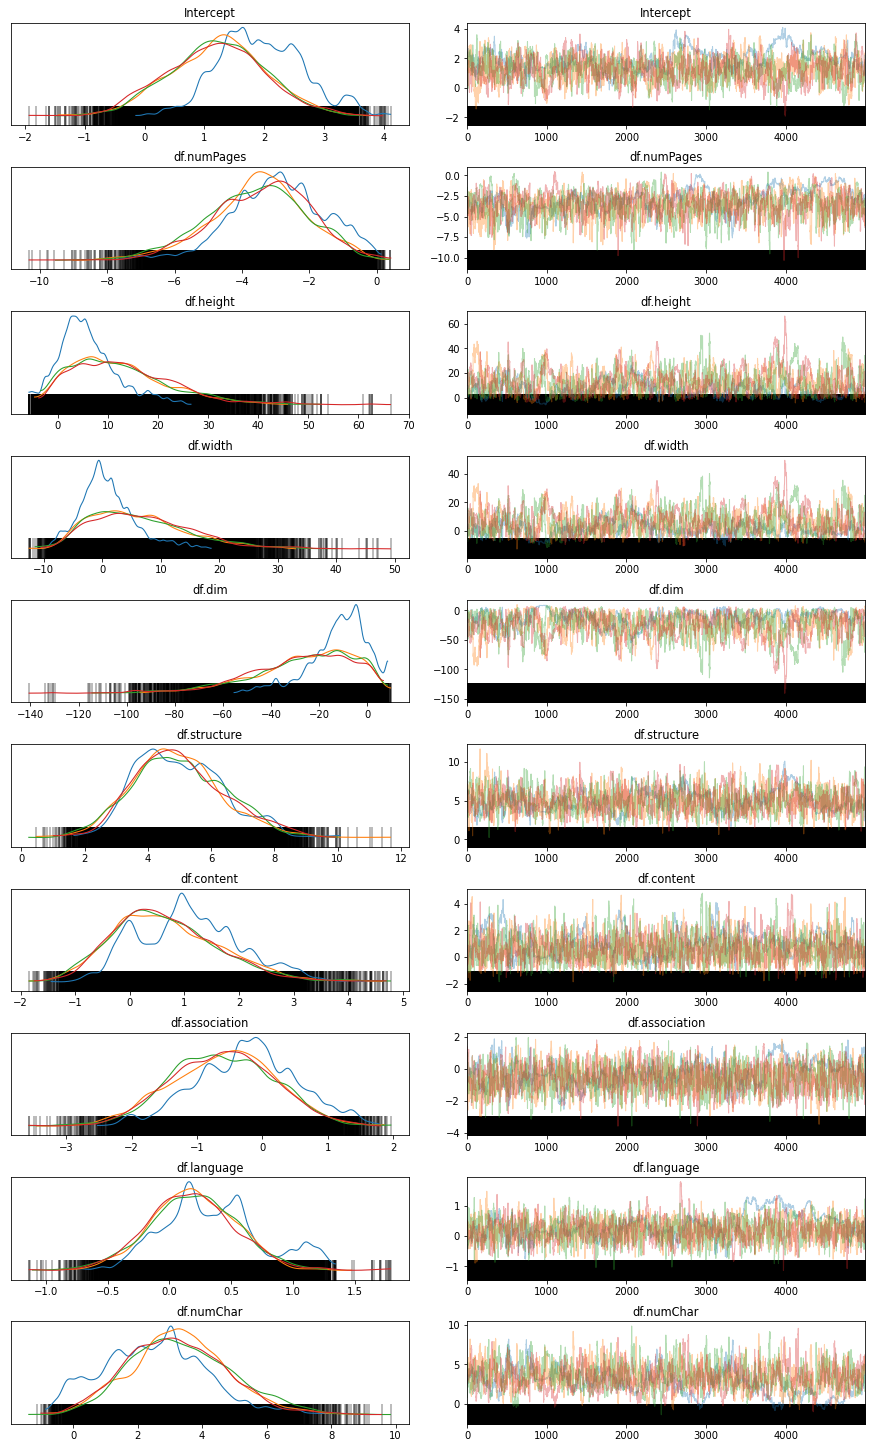

In [28]:
import arviz as az
az.plot_trace(trace)

In [29]:
pm.summary(trace).round(2)

/home/hc5hq/.local/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,1.39,0.85,-0.25,2.94,0.16,0.12,28.0,25.0,28.0,139.0,1.12
df.numPages,-3.36,1.48,-6.12,-0.58,0.19,0.13,63.0,63.0,57.0,243.0,1.07
df.height,10.98,9.53,-3.04,29.22,1.18,0.84,65.0,65.0,60.0,379.0,1.07
df.width,5.08,8.10,-7.90,20.30,0.93,0.66,77.0,77.0,88.0,354.0,1.06
df.dim,-22.82,20.46,-60.79,6.95,2.58,1.83,63.0,63.0,59.0,372.0,1.07
df.structure,4.99,1.44,2.59,7.91,0.08,0.06,372.0,337.0,399.0,497.0,1.00
df.content,0.77,0.99,-0.96,2.65,0.05,0.04,333.0,333.0,317.0,582.0,1.03
df.association,-0.51,0.80,-2.02,0.98,0.08,0.06,90.0,90.0,87.0,274.0,1.05
df.language,0.23,0.37,-0.53,0.93,0.04,0.04,72.0,55.0,83.0,58.0,1.05
df.numChar,3.11,1.60,-0.16,5.94,0.23,0.16,48.0,48.0,43.0,101.0,1.08


## OLS regression summary

In [30]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

In [31]:
X = df[["numPages", "height", "width", "dim", "structure", "content", "association", "language", "numChar"]]
y = df["researchPublication"]
# building the model and fitting the data 
log_reg = sm.Logit(y, add_constant(X)).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.335658
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     researchPublication   No. Observations:                  119
Model:                           Logit   Df Residuals:                      109
Method:                            MLE   Df Model:                            9
Date:                 Sun, 15 Nov 2020   Pseudo R-squ.:                  0.4869
Time:                         11:29:26   Log-Likelihood:                -39.943
converged:                        True   LL-Null:                       -77.848
Covariance Type:             nonrobust   LLR p-value:                 1.093e-12
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.0455      0.855      1.223      0.221      -0.630       2.721
numPages       -2.6593      1.324     -2.009      0.045      -5.254      -0.065
height          9.3919     11.302      0.831      0.406     -12.760      31.544
width           5.0561      9.943      0.508      0.611     -14.432      24.544
dim           -19.8738     24.691     -0.805      0.421     -68.268      28.520
structure       4.2396      1.294      3.277      0.001       1.704       6.775
content         0.2907      0.820      0.354      0.723      -1.317       1.898
association    -0.5078      0.765     -0.664      0.507      -2.007       0.992
language        0.2199      0.320      0.686      0.493      -0.408       0.848
numChar         2.5044      1.419      1.765      0.078      -0.277       5.286
===============================================================================
"""

## Bayesian Model Averaging

In [32]:
## BMA 
from mpmath import mp
mp.dps = 50
class BMA:
    
    def __init__(self, y, X, **kwargs):
        # Setup the basic variables.
        self.y = y
        self.X = X
        self.names = list(X.columns)
        self.nRows, self.nCols = np.shape(X)
        self.likelihoods = mp.zeros(self.nCols,1)
        self.likelihoods_all = {}
        self.coefficients_mp = mp.zeros(self.nCols,1)
        self.coefficients = np.zeros(self.nCols)
        self.probabilities = np.zeros(self.nCols)
        # Check the max model size. (Max number of predictor variables to use in a model.)
        # This can be used to reduce the runtime but not doing an exhaustive sampling.
        if 'MaxVars' in kwargs.keys():
            self.MaxVars = kwargs['MaxVars']
        else:
            self.MaxVars = self.nCols  
        # Prepare the priors if they are provided.
        # The priors are provided for the individual regressor variables.
        # The prior for a model is the product of the priors on the variables in the model.
        if 'Priors' in kwargs.keys():
            if np.size(kwargs['Priors']) == self.nCols:
                self.Priors = kwargs['Priors']
            else:
                print("WARNING: Provided priors error.  Using equal priors instead.")
                print("The priors should be a numpy array of length equal tot he number of regressor variables.")
                self.Priors = np.ones(self.nCols)  
        else:
            self.Priors = np.ones(self.nCols)  
        if 'Verbose' in kwargs.keys():
            self.Verbose = kwargs['Verbose'] 
        else:
            self.Verbose = False 
        if 'RegType' in kwargs.keys():
            self.RegType = kwargs['RegType'] 
        else:
            self.RegType = 'LS' 
        
    def fit(self):
        # Perform the Bayesian Model Averaging
        
        # Initialize the sum of the likelihoods for all the models to zero.  
        # This will be the 'normalization' denominator in Bayes Theorem.
        likelighood_sum = 0
        
        # To facilitate iterating through all possible models, we start by iterating thorugh
        # the number of elements in the model.  
        max_likelihood = 0
        for num_elements in range(1,self.MaxVars+1): 
            
            if self.Verbose == True:
                print("Computing BMA for models of size: ", num_elements)
            
            # Make a list of all index sets of models of this size.
            Models_next = list(combinations(list(range(self.nCols)), num_elements)) 
             
            # Occam's window - compute the candidate models to use for the next iteration
            # Models_previous: the set of models from the previous iteration that satisfy (likelihhod > max_likelihhod/20)
            # Models_next:     the set of candidate models for the next iteration
            # Models_current:  the set of models from Models_next that can be consturcted by adding one new variable
            #                    to a model from Models_previous
            if num_elements == 1:
                Models_current = Models_next
                Models_previous = []
            else:
                idx_keep = np.zeros(len(Models_next))
                for M_new,idx in zip(Models_next,range(len(Models_next))):
                    for M_good in Models_previous:
                        if(all(x in M_new for x in M_good)):
                            idx_keep[idx] = 1
                            break
                        else:
                            pass
                Models_current = np.asarray(Models_next)[np.where(idx_keep==1)].tolist()
                Models_previous = []
                        
            
            # Iterate through all possible models of the given size.
            for model_index_set in Models_current:
                
                # Compute the linear regression for this given model. 
                model_X = self.X.iloc[:,list(model_index_set)]
                if self.RegType == 'Logit':
                    model_regr = sm.Logit(self.y, model_X).fit(disp=0)
                else:
                    model_regr = OLS(self.y, model_X).fit()
                
                # Compute the likelihood (times the prior) for the model. 
                model_likelihood = mp.exp(-model_regr.bic/2)*np.prod(self.Priors[list(model_index_set)])
                    
                if (model_likelihood > max_likelihood/20):
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"likelihood=",model_likelihood)
                    self.likelihoods_all[str(model_index_set)] = model_likelihood
                    
                    # Add this likelihood to the running tally of likelihoods.
                    likelighood_sum = mp.fadd(likelighood_sum, model_likelihood)

                    # Add this likelihood (times the priors) to the running tally
                    # of likelihoods for each variable in the model.
                    for idx, i in zip(model_index_set, range(num_elements)):
                        self.likelihoods[idx] = mp.fadd(self.likelihoods[idx], model_likelihood, prec=1000)
                        self.coefficients_mp[idx] = mp.fadd(self.coefficients_mp[idx], model_regr.params[i]*model_likelihood, prec=1000)
                    Models_previous.append(model_index_set) # add this model to the list of good models
                    max_likelihood = np.max([max_likelihood,model_likelihood]) # get the new max likelihood if it is this model
                else:
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"rejected by Occam's window")
                    

        # Divide by the denominator in Bayes theorem to normalize the probabilities 
        # sum to one.
        self.likelighood_sum = likelighood_sum
        for idx in range(self.nCols):
            self.probabilities[idx] = mp.fdiv(self.likelihoods[idx],likelighood_sum, prec=1000)
            self.coefficients[idx] = mp.fdiv(self.coefficients_mp[idx],likelighood_sum, prec=1000)
        
        # Return the new BMA object as an output.
        return self
    
    def predict(self, data):
        data = np.asarray(data)
        if self.RegType == 'Logit':
            try:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data)))
            except:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data.T)))
        else:
            try:
                result = np.dot(self.coefficients,data)
            except:
                result = np.dot(self.coefficients,data.T)
        
        return result  
        
    def summary(self):
        # Return the BMA results as a data frame for easy viewing.
        df = pd.DataFrame([self.names, list(self.probabilities), list(self.coefficients)], 
             ["Variable Name", "Probability", "Avg. Coefficient"]).T
        return df  

In [33]:
X = df[["numPages", "height", "width", "dim", "structure", "content", "association", "language", "numChar"]]
y = df["researchPublication"]
result = BMA(y ,add_constant(X), RegType = 'Logit', Verbose=True).fit()

Computing BMA for models of size:  1
Model Variables: (0,) likelihood= 1.4227045382397855308525623096484293851329955187107e-35
Model Variables: (1,) rejected by Occam's window
Model Variables: (2,) rejected by Occam's window
Model Variables: (3,) likelihood= 1.138032884424578955030718807782180819288052885991e-32
Model Variables: (4,) likelihood= 1.255191157452681054526119553510295864273126605461e-33
Model Variables: (5,) likelihood= 3.310112886360251785689930524415019185217433486895e-32
Model Variables: (6,) rejected by Occam's window
Model Variables: (7,) rejected by Occam's window
Model Variables: (8,) rejected by Occam's window
Model Variables: (9,) rejected by Occam's window
Computing BMA for models of size:  2
Model Variables: [0, 1] rejected by Occam's window
Model Variables: [0, 2] rejected by Occam's window
Model Variables: [0, 3] likelihood= 4.2466704631309476873442676794241986844967782536587e-32
Model Variables: [0, 4] likelihood= 3.6185945489042081772480479046580205455797796

In [34]:
result.summary() 

,Variable Name,Probability,Avg. Coefficient
0,const,0.999975,1.87049
1,numPages,0.144092,-0.239488
2,height,0.110828,0.195444
3,width,0.93856,-2.04035
4,dim,0.109098,-0.309707
5,structure,1,4.38695
6,content,0.0632273,0.0380169
7,association,0.0495989,-0.0139534
8,language,0.0696211,0.0190583
9,numChar,0.12197,0.213403


## ADVI and ELBO 

In [35]:
## advi method
with pm.Model() as model:
    pm.glm.GLM.from_formula('df.researchPublication~ df.numPages + df.height + df.width + df.dim + df.structure + df.content + df.association + df.association + df.language + df.numChar',
                            df,
                            family=pm.glm.families.Binomial())

    #trace = pm.sample(5000)
    approx = pm.fit(5000, method = 'advi')

Finished [100%]: Average Loss = 121.73


In [36]:
import seaborn as sns

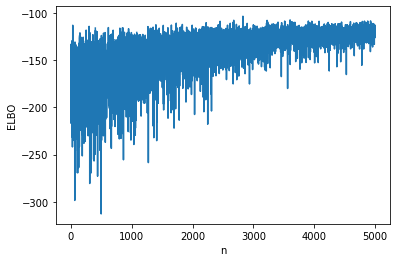

In [37]:
advi_elbo = pd.DataFrame(
    {'ELBO': -approx.hist,
     'n': np.arange(approx.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)

In [38]:
trace_VI = approx.sample(draws=5000)

In [39]:
def plot_traces(traces, retain=0):
    '''
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:],
                      lines=tuple([(k, {}, v['mean'])
                                   for k, v in pm.summary(traces[-retain:]).iterrows()]))

    for i, mn in enumerate(pm.summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

/home/hc5hq/.local/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input

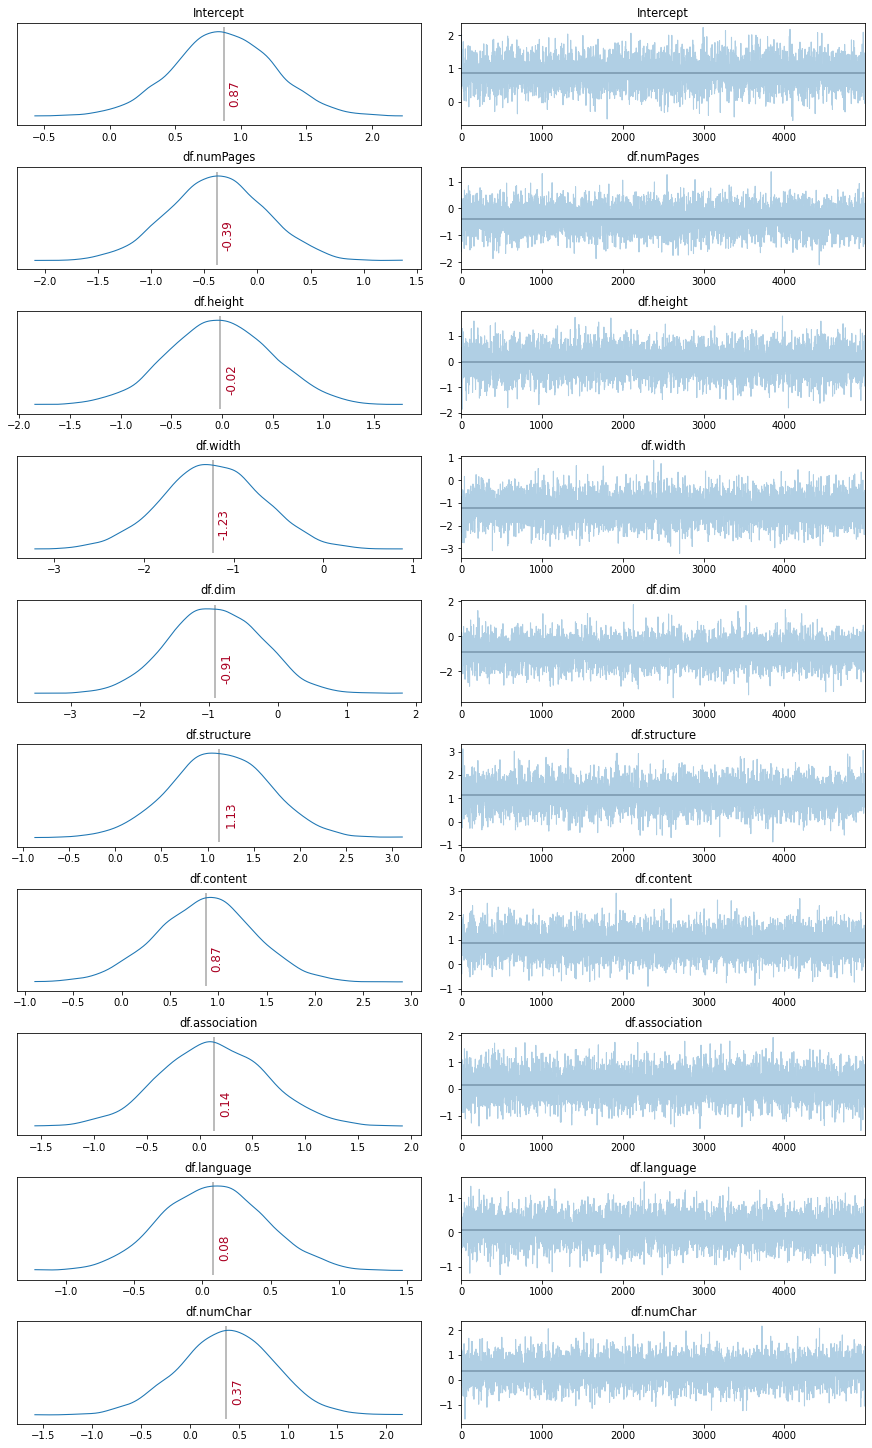

In [40]:
plot_traces(trace_VI)

In [41]:
pm.summary(trace_VI).round(2)

/home/hc5hq/.local/lib/python3.7/site-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.87,0.39,0.12,1.58,0.00,0.00,5034.0,4976.0,5034.0,4982.0,NaN
df.numPages,-0.38,0.45,-1.25,0.46,0.01,0.00,5168.0,5147.0,5165.0,4910.0,NaN
df.height,-0.02,0.51,-0.95,0.97,0.01,0.00,5004.0,4928.0,5006.0,5068.0,NaN
df.width,-1.23,0.56,-2.25,-0.16,0.01,0.01,4501.0,4501.0,4503.0,4453.0,NaN
df.dim,-0.91,0.67,-2.17,0.32,0.01,0.01,4986.0,4800.0,4979.0,4861.0,NaN
df.structure,1.13,0.54,0.11,2.12,0.01,0.01,4562.0,4562.0,4575.0,4855.0,NaN
df.content,0.87,0.51,-0.08,1.82,0.01,0.00,5334.0,5194.0,5338.0,4901.0,NaN
df.association,0.14,0.50,-0.75,1.14,0.01,0.00,4759.0,4759.0,4758.0,4570.0,NaN
df.language,0.08,0.38,-0.57,0.86,0.00,0.00,5163.0,4631.0,5162.0,4501.0,NaN
df.numChar,0.37,0.48,-0.54,1.25,0.01,0.00,4719.0,4719.0,4733.0,4791.0,NaN


## Exploratory Data Analysis

In [42]:
## EDA
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

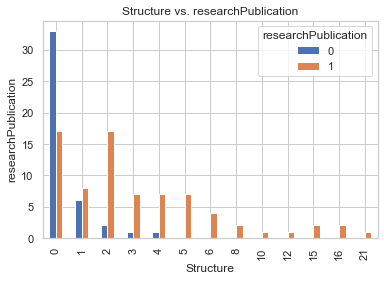

In [43]:
%matplotlib inline
pd.crosstab(finalDataset.structure,finalDataset.researchPublication).plot(kind='bar')
plt.title('Structure vs. researchPublication')
plt.xlabel('Structure')
plt.ylabel('researchPublication')
plt.savefig('featureAnalysis')

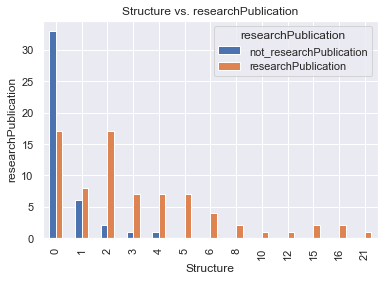

In [62]:
%matplotlib inline
pd.crosstab(df1.structure,df1.researchPublication).plot(kind='bar')
plt.title('Structure vs. researchPublication')
plt.xlabel('Structure')
plt.ylabel('researchPublication')
plt.savefig('featureAnalysis')

In [44]:
df.corr()

,numPages,height,width,dim,structure,content,association,language,numChar,researchPublication
numPages,1.000000,-0.175951,-0.029753,-0.109139,0.324234,0.397362,0.570451,0.065298,0.770433,0.067400
height,-0.175951,1.000000,0.407097,0.874474,-0.054750,-0.035784,-0.084993,-0.110163,-0.140629,-0.135889
width,-0.029753,0.407097,1.000000,0.764391,-0.031820,-0.008207,0.058053,-0.173147,0.070916,-0.373306
dim,-0.109139,0.874474,0.764391,1.000000,-0.056493,-0.037398,-0.022996,-0.135010,-0.037706,-0.253524
structure,0.324234,-0.054750,-0.031820,-0.056493,1.000000,0.720432,0.487697,-0.352424,0.475530,0.404511
content,0.397362,-0.035784,-0.008207,-0.037398,0.720432,1.000000,0.482866,-0.330508,0.542953,0.359592
association,0.570451,-0.084993,0.058053,-0.022996,0.487697,0.482866,1.000000,-0.219061,0.766559,0.143844
language,0.065298,-0.110163,-0.173147,-0.135010,-0.352424,-0.330508,-0.219061,1.000000,-0.111405,-0.046275
numChar,0.770433,-0.140629,0.070916,-0.037706,0.475530,0.542953,0.766559,-0.111405,1.000000,0.198891
researchPublication,0.067400,-0.135889,-0.373306,-0.253524,0.404511,0.359592,0.143844,-0.046275,0.198891,1.000000


## Heatmp

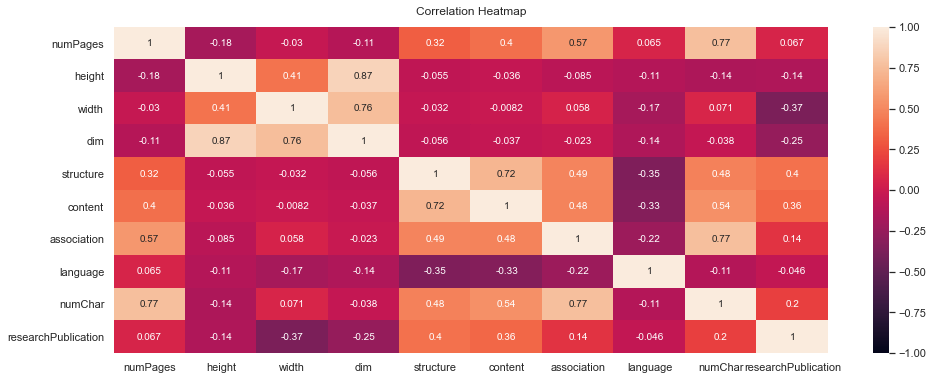

In [45]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

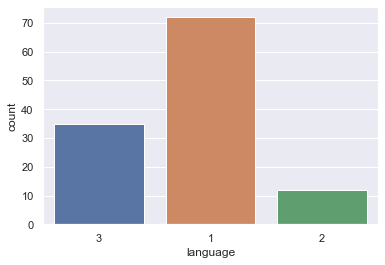

In [46]:
## language
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="language", data = finalDataset)

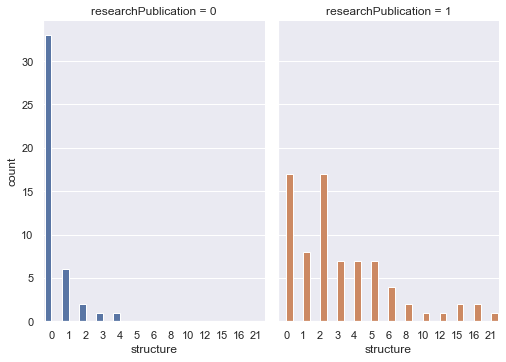

In [47]:
## structure
g = sns.catplot(x="structure", hue="researchPublication", col="researchPublication",
                data=finalDataset, kind="count",
                height=5, aspect=.7);

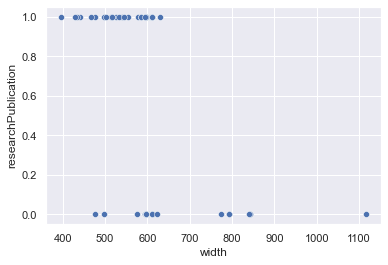

In [48]:
# width
## structure
sns.scatterplot(x = "width", y = "researchPublication", data=finalDataset)
plt.show()

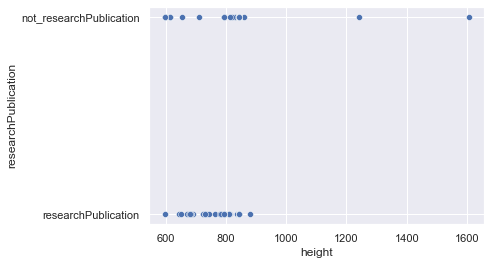

In [65]:
# height
## structure
sns.scatterplot(x = "height", y = "researchPublication", data=finalDataset)
plt.show()

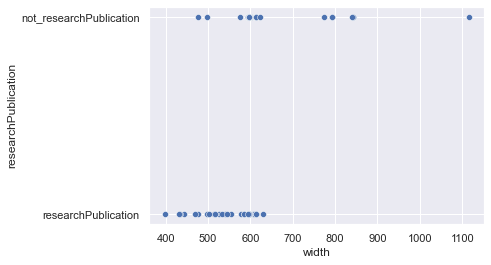

In [67]:
# Width
## structure
sns.scatterplot(x = "width", y = "researchPublication", data=finalDataset)
plt.show()

## Machine Learning - Logistic Regression

In [49]:
## Machine learning
# Import the dependencies
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [50]:
#Prepare the training set

# X = feature values, all the columns except the last column
X = df.iloc[:, :-1]

# y = target values, last column of the data frame
y = df.iloc[:, -1]

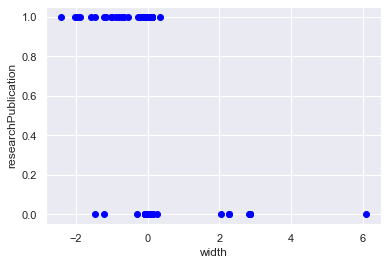

In [51]:
# Plot the relation of each feature with each species

plt.xlabel('width')
plt.ylabel('researchPublication')
pltX = df.loc[:, 'width']
pltY = df.loc[:,'researchPublication']
plt.scatter(pltX, pltY, color='blue', label='width')

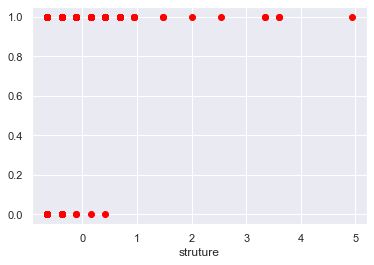

In [52]:
plt.xlabel('struture')
pltX = df.loc[:, 'structure']
pltY = df.loc[:,'researchPublication']
plt.scatter(pltX, pltY, color='red', label='structure')

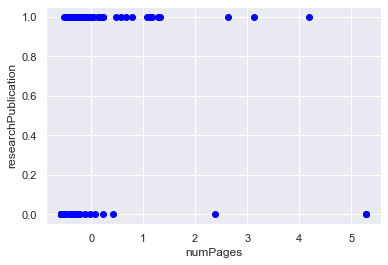

In [53]:
# Plot the relation of each feature with each species

plt.xlabel('numPages')
plt.ylabel('researchPublication')
pltX = df.loc[:, 'numPages']
pltY = df.loc[:,'researchPublication']
plt.scatter(pltX, pltY, color='blue', label='numPages')

In [54]:
#Split the data into 50% training and 20% testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2021)

In [55]:
#Train the model
model = LogisticRegression()
model.fit(x_train, y_train) #Training the model

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
#Test the model
predictions = model.predict(x_test)
print(predictions)# printing predictions

print()# Printing new line

#Check precision, recall, f1-score
print( classification_report(y_test, predictions) )

print( accuracy_score(y_test, predictions))

[0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1
 1 1 0 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 1 1 1 1 1]

              precision    recall  f1-score   support

           0       0.68      0.59      0.63        22
           1       0.78      0.84      0.81        38

    accuracy                           0.75        60
   macro avg       0.73      0.72      0.72        60
weighted avg       0.75      0.75      0.75        60

0.75
